In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import dill

In [32]:
SP = pd.read_csv('mybl_ticker.csv').dropna()
SP.head()

,date_added,GSPC,VIX,TNX
0,2001-01-30,1373.729980,22.570000,5.212
1,2001-01-31,1366.010010,22.020000,5.179
2,2001-02-01,1373.469971,21.660000,5.061
3,2001-02-02,1349.469971,21.950001,5.138
4,2001-02-05,1354.310059,22.190001,5.146


In [66]:
SP['corr'] = SP.GSPC.rolling(window=5).mean()\
.rolling(window=5).corr(SP.VIX)

#Подсчет t-статистики для корреляции
def t_st(x):
    t = x['corr'] * (100 - 2)**(1/2)/(1 - x['corr']**2)**(1/2)
    t1 = stats.t.ppf(0.01/2, df=100 - 2)
    t2 = stats.t.ppf(1 - 0.01/2, df=100 - 2)

    corrt = pd.DataFrame({'corr': x['corr'], 't': t, 't1': np.ones(len(t))*t1, 't2': np.ones(len(t))*t2})
    return corrt

#Построение графиков двух рядов и корреляции с t-статистиой
def grapher(x):
    fig, ax = plt.subplots()
    ax.set_title('x и y')
    fig.set_size_inches(10, 5)
#     lns1 = ax.plot(x.Close.rolling(window=100, center=True).mean(), label='S&P 500')
    lns1 = ax.plot(x.GSPC, linewidth=1, label='x')
    ax2 = ax.twinx()
    lns2 = ax2.plot(x.VIX, linewidth=1, c='g', label='y')

    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='upper left')

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    ax.set_title('Корреляция между x и y')
    ax2 = ax.twinx()
    lns1 = ax.plot(corrt.t, label='t-значение')
    lns2 = ax.plot(corrt.t1, linestyle=':', c='k', label='границы критической области')
    lns3 = ax.plot(corrt.t2, linestyle=':', c='k')
    lns4 = ax2.plot(corrt['corr'], linewidth=1, linestyle='--', c='r', label='корреляция')
    ax2.set_frame_on(True)

    lns = lns1+lns2+lns4
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc='upper left')

    plt.show()


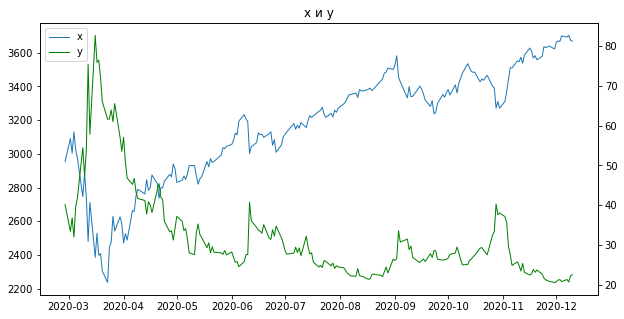

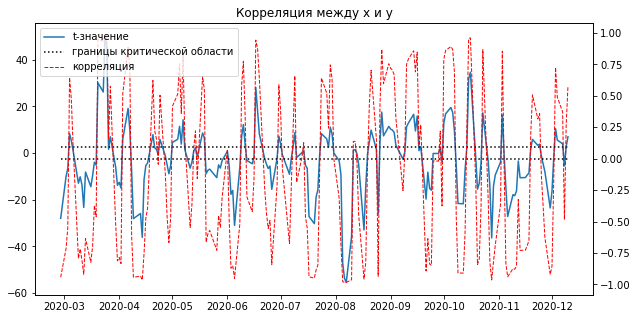

In [69]:
SP.date_added = pd.to_datetime(SP.date_added)
SP.index = SP.date_added
corrt = t_st(SP[-200:])
grapher(SP[-200:])

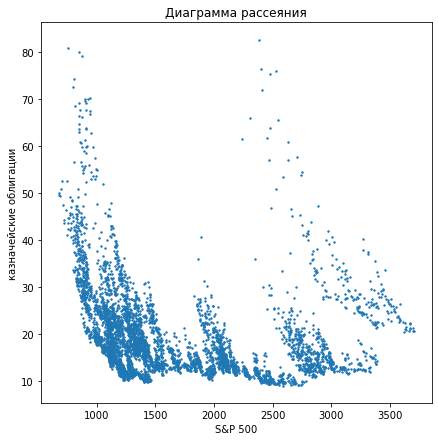

-0.27351660615553547

In [51]:
plt.figure(figsize=(7,7))
plt.scatter(SP.GSPC, SP.VIX, s=2)
plt.title('Диаграмма рассеяния')
plt.xlabel('S&P 500')
plt.ylabel('казначейские облигации')
plt.show()
SP.GSPC.corr(SP.VIX)

In [1046]:
# SP.rename(columns={'GOLDAMGBD228NLBM': 'Close'}, inplace=True)
SP.Close = SP.Close.apply(pd.to_numeric, errors='coerce')
SP.Close = SP.Close.fillna(method='ffill')

In [1047]:
SP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7791 entries, 0 to 7790
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       7791 non-null   object 
 1   Open       7791 non-null   float64
 2   High       7791 non-null   float64
 3   Low        7791 non-null   float64
 4   Close      7791 non-null   float64
 5   Adj Close  7791 non-null   float64
 6   Volume     7791 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 486.9+ KB


In [1048]:
SP = SP.iloc[::-1]

In [1049]:
# chnd = (SP.Close.iloc[0]/SP.Close.iloc[0 + period_pred] - 1)*100
# chnd, SP.Close.iloc[0], SP.Close.iloc[0 + period_pred]

In [1050]:
df = []

#с конца всего датасета
for i in range(7000):
    period_pred = 15
    chnd = (SP.Close.iloc[i]/SP.Close.iloc[i + period_pred] - 1)*100
    row = []
    if chnd < -5:
        row.append(1)
    else:
        row.append(0)
    for j in (1, 2, 3, 4, 5, 6, 8, 10, 13, 17, 22):
        row.append(SP.Close.iloc[j + i])
    df.append(row)

In [1051]:
df = pd.DataFrame(df)
df.columns = [str(i) for i in range(12)]
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1,20.570000,20.840000,21.250000,21.639999,22.660000,23.700001,23.840000,22.450001,23.450001,27.580000,37.590000
1,1,20.840000,21.250000,21.639999,22.660000,23.700001,23.110001,22.709999,23.100000,24.799999,29.570000,40.279999
2,1,21.250000,21.639999,22.660000,23.700001,23.110001,23.840000,22.450001,25.350000,25.750000,35.549999,33.349998
3,1,21.639999,22.660000,23.700001,23.110001,23.840000,22.709999,23.100000,23.450001,24.860001,37.130001,32.459999
4,1,22.660000,23.700001,23.110001,23.840000,22.709999,22.450001,25.350000,24.799999,27.580000,38.020000,27.549999


In [1052]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, classification_report, precision_recall_curve, confusion_matrix

In [1053]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['0'], 1), df['0'], random_state=0)

In [1054]:
with open('rf.dill', 'wb') as in_strm:
    in_strm.write(dill.dumps(pipeline))

In [1055]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
preds = rf.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision/50 * recall) / (precision/50 + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%.3f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.870, F-Score=0.036, Precision=0.970, Recall=0.279


In [1056]:
y_test.value_counts(normalize=True)

0    0.597143
1    0.402857
Name: 0, dtype: float64

In [1057]:
preds = rf.predict_proba(df.drop(['0'], 1))[:, 1]
preds

array([0.97, 0.96, 0.97, ..., 0.02, 0.03, 0.01])

In [1058]:
len(preds)

7000

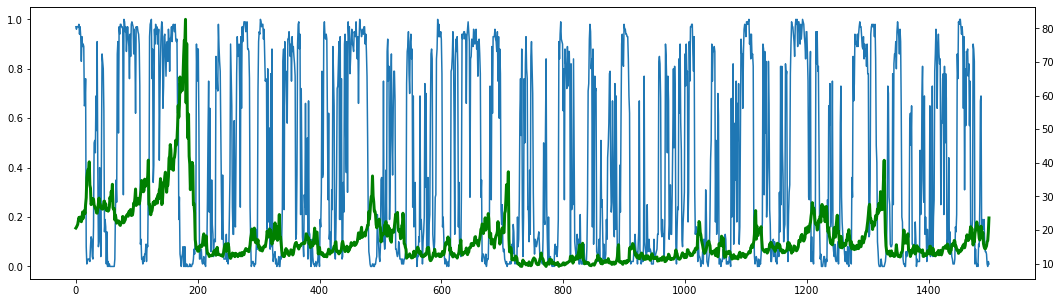

In [1059]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(18, 5)
lns1 = ax.plot(preds[:1500])
ax2 = ax.twinx()
lns2 = ax2.plot(df['1'][:1500], linewidth=3, c='g', label='y')
lns = lns1+lns2
plt.show()

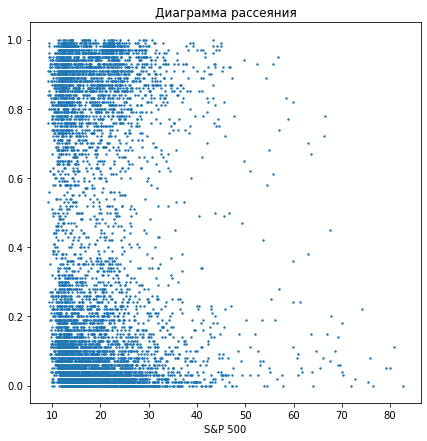

-0.06790608109061445

In [1060]:
plt.figure(figsize=(7,7))
plt.scatter(df['1'], preds, s=2)
plt.title('Диаграмма рассеяния')
plt.xlabel('S&P 500')
# plt.ylabel('казначейские облигации')
plt.show()
df['1'].corr(pd.Series(preds))
